# Regression with Text Input Using BERT and Transformers

- Based on this [medium blog post](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13);

## Setup

In [1]:
%%time

# Load packages.
import torch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from evaluate.loading import load
from torch.utils.data import DataLoader

CPU times: user 3.66 s, sys: 1.54 s, total: 5.2 s
Wall time: 8.45 s


In [2]:
# Clear the GPU cache to free up memory.
torch.cuda.empty_cache()

## Dataset

### Download

In [3]:
!pwd

/llm_app


In [4]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines


--2025-01-07 18:40:02--  https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245947 (240K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’

/llm_app/notebooks/ 100%[===================>] 240.18K  1.42MB/s    in 0.2s    

2025-01-07 18:40:03 (1.42 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’ saved [245947/245947]



In [5]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines

--2025-01-07 18:40:04--  https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53162 (52K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’

/llm_app/notebooks/ 100%[===================>]  51.92K  --.-KB/s    in 0.04s   

2025-01-07 18:40:05 (1.36 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’ saved [53162/53162]



In [6]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines

--2025-01-07 18:40:06--  https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54424 (53K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’

/llm_app/notebooks/ 100%[===================>]  53.15K  --.-KB/s    in 0.03s   

2025-01-07 18:40:07 (1.50 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’ saved [54424/54424]



### Understanding

In [7]:
raw_train_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines")
raw_val_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines")
raw_test_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines")

# Alex: reduce datasets by half the original size (in order to avoid memory and time constraints).
idx_train = np.random.choice(
    a=np.arange(raw_train_ds.num_rows), 
    size=int(raw_train_ds.num_rows/2),
    replace=False
)
idx_train.sort()
raw_train_ds = raw_train_ds.select(idx_train)

idx_val = np.random.choice(
    a=np.arange(raw_val_ds.num_rows), 
    size=int(raw_val_ds.num_rows/2),
    replace=False
)
idx_val.sort()
raw_val_ds = raw_val_ds.select(idx_val)

idx_test = np.random.choice(
    a=np.arange(raw_test_ds.num_rows), 
    size=int(raw_test_ds.num_rows/2),
    replace=False
)
idx_test.sort()
raw_test_ds = raw_test_ds.select(idx_test)

# This line prints the description of train_ds.
raw_train_ds, raw_val_ds, raw_test_ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 330
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 71
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 71
 }))

In [8]:
raw_train_ds[0]

{'id': 934,
 'text': "C'est de loin la pire expérience que j'ai jamais eu. Ils font absolument tout pour vous rabaisser et vous radier. Je n'ai eu aucune proposition d'offre d'emploi depuis que je suis inscrite. Conseillers incompétents et irrespectueux... Plus d'1h de retard lors des entretiens, complètement désorganisée, pas professionnelle du tout, il faut changer de métier si cela ne vous convient pas ! Je déconseille fortement !",
 'uuid': '602d0af9679d97052cdab95d',
 'score': 0}

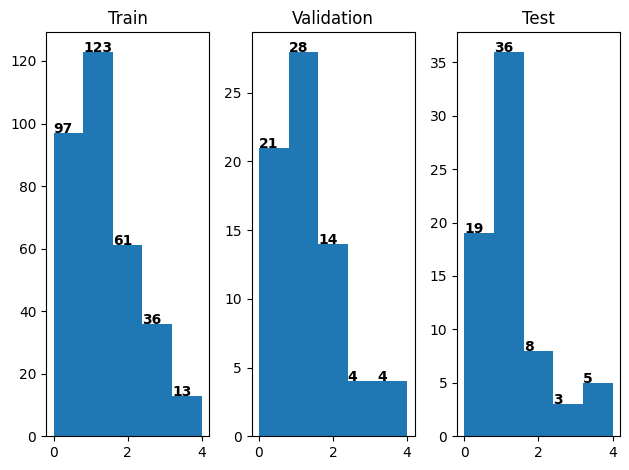

In [9]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(raw_train_ds["score"], bins=5)
val_distributions = axs[1].hist(raw_val_ds["score"], bins=5)
test_distributions = axs[2].hist(raw_test_ds["score"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


## Fine-tuning with a Text Classification Model

In [10]:
%%time

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 28 # 256
BATCH_SIZE = 4  # 16
EPOCHS = 5      # 20

# Let's name the classes 0, 1, 2, 3, 4 like their indices.
id2label = {k:k for k in range(5)}
label2id = {k:k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be ex

CPU times: user 1.38 s, sys: 783 ms, total: 2.16 s
Wall time: 5.43 s


### Prepare Datasets

In [11]:
%%time

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):
    
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = label

    return examples


for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

CPU times: user 586 ms, sys: 27.7 ms, total: 614 ms
Wall time: 641 ms


### Metrics

In [12]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels)

In [13]:
training_args = TrainingArguments(
    output_dir="/llm_app/models/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [14]:
%%time

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.343826,0.450704
2,No log,1.210874,0.492958
3,No log,1.172164,0.549296
4,No log,1.158564,0.521127
5,No log,1.154716,0.535211


CPU times: user 34min 7s, sys: 6min 5s, total: 40min 12s
Wall time: 40min 56s


TrainOutput(global_step=415, training_loss=1.1208355639354293, metrics={'train_runtime': 2452.1543, 'train_samples_per_second': 0.673, 'train_steps_per_second': 0.169, 'total_flos': 217072467532800.0, 'train_loss': 1.1208355639354293, 'epoch': 5.0})

### Evaluation

In [17]:
trainer.eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 71
})

In [15]:
%%time

trainer.evaluate()

CPU times: user 23.8 s, sys: 42.8 ms, total: 23.8 s
Wall time: 23.9 s


{'eval_loss': 1.1721644401550293,
 'eval_accuracy': 0.5492957746478874,
 'eval_runtime': 23.9229,
 'eval_samples_per_second': 2.968,
 'eval_steps_per_second': 0.752,
 'epoch': 5.0}

In [18]:
%%time

trainer.eval_dataset=ds["test"]
trainer.evaluate()

CPU times: user 16.9 s, sys: 43.2 ms, total: 17 s
Wall time: 17.1 s


{'eval_loss': 1.0511820316314697,
 'eval_accuracy': 0.5633802816901409,
 'eval_runtime': 17.0912,
 'eval_samples_per_second': 4.154,
 'eval_steps_per_second': 1.053,
 'epoch': 5.0}

### Prediction

In [19]:
%%time

input_texts = [
    "C'est très bien", 
    "Je vais y aller.", 
    "J'en ai marre.", 
    "Vous ne foutez rien !!!", 
    "Je vous remercie infiniment pour cet excellent service !!!"
]

# Encode the text.
encoded = tokenizer(
    input_texts, 
    truncation=True, 
    padding="max_length", 
    max_length=28, # 256
    return_tensors="pt"
).to("cuda")

# Call the model to predict under the format of logits of 5 classes
logits = model(**encoded).logits

# Get the class
torch.argmax(logits, axis=1)

CPU times: user 27.9 ms, sys: 12 ms, total: 39.9 ms
Wall time: 64.2 ms


tensor([2, 2, 1, 1, 2], device='cuda:0')

## Fine-tuning with a Regression Model

### Setup

In [20]:
# Clear the GPU cache to free up memory.
torch.cuda.empty_cache()

In [21]:
%%time

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 28 # 256
BATCH_SIZE = 4  # 16
EPOCHS = 5      # 20

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be ex

CPU times: user 1.36 s, sys: 329 ms, total: 1.68 s
Wall time: 2.13 s


### Prepare Datasets

In [22]:
%%time

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):
    
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number.
    examples["label"] = float(label)
    
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

CPU times: user 618 ms, sys: 20.4 ms, total: 639 ms
Wall time: 767 ms


### Metrics